In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
path_raw_results: str = '../../benchmark_results/raw.csv'
df: pd.DataFrame = pd.read_csv(path_raw_results)

base_model_name: str = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'

## Group Data

In [12]:
columns_to_keep_raw_csv: list = ['game', 'model', 'experiment', 'episode', 'Aborted', 'Lose', 'Success']

def group_raw_csv(data: pd.DataFrame, columns_to_keep: list[str]) -> pd.DataFrame:
    df: pd.DataFrame = data.pivot_table(
        index=['game', 'model', 'experiment', 'episode'],
        columns=['metric'],
        values='value'
    ).reset_index()

    columns_to_drop: list = [column for column in list(df.keys()) if column not in columns_to_keep]
    return df.drop(columns=columns_to_drop, axis=0)

clean_csv_data: pd.DataFrame = group_raw_csv(data=df, columns_to_keep=columns_to_keep_raw_csv)

In [13]:
clean_csv_data.head()

metric,game,model,experiment,episode,Aborted,Lose,Success
0,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_0,1.0,0.0,0.0
1,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_1,1.0,0.0,0.0
2,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_10,1.0,0.0,0.0
3,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_11,1.0,0.0,0.0
4,imagegame,ClemBench-SFT-Nicola-Test-t0.0--ClemBench-SFT-...,0_compact_grids,episode_12,1.0,0.0,0.0


In [21]:
base_model_data: pd.DataFrame = clean_csv_data[clean_csv_data.model == base_model_name]
base_model_image_game_data: pd.DataFrame = base_model_data[base_model_data.game == 'imagegame']

In [22]:
base_model_image_game_data.head().head()

metric,game,model,experiment,episode,Aborted,Lose,Success
160,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_0,0.0,1.0,0.0
161,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_1,0.0,1.0,0.0
162,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_10,0.0,1.0,0.0
163,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_11,0.0,1.0,0.0
164,imagegame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_compact_grids,episode_12,0.0,1.0,0.0


In [23]:
len(base_model_image_game_data)

40

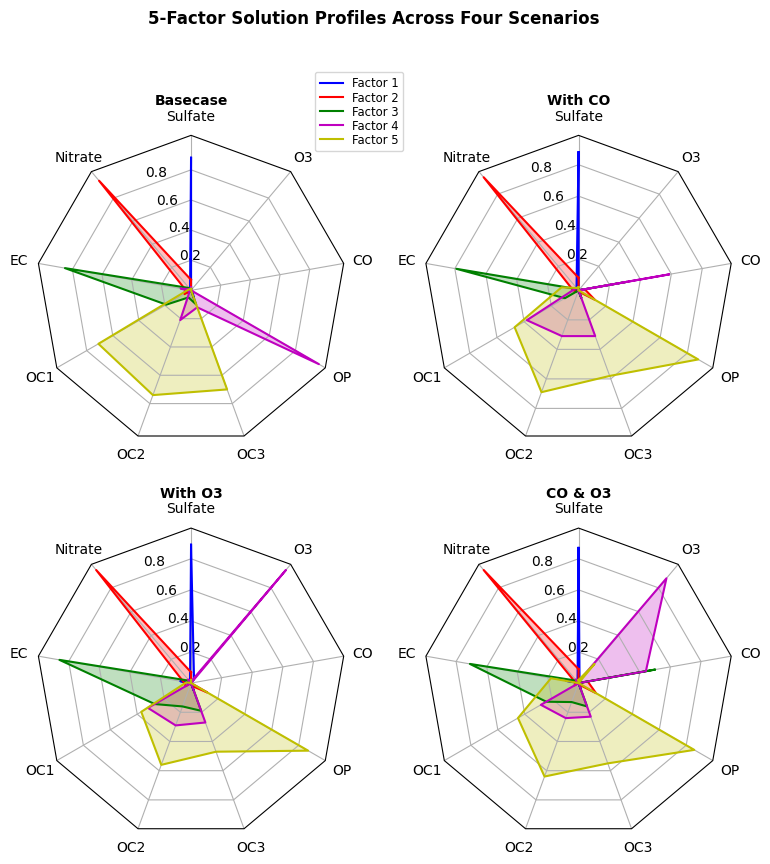